Retrieve job data from a PostgreSQL database and sort by date. 

In [33]:
import psycopg2
import pandas as pd
from urllib import parse
import os
import sys

# Add the path to the folder containing the env.py
sys.path.append('../')
from env import *

DATABASE_URL = os.environ['DATABASE_URL']
parse.uses_netloc.append('postgres')
url = parse.urlparse(DATABASE_URL)
DB_HOST = url.hostname
DB_PORT = url.port
DB_NAME = url.path[1:]
DB_USER = url.username
DB_PASSWORD = url.password

conn = psycopg2.connect(host=DB_HOST, port=DB_PORT,
                        database=DB_NAME, user=DB_USER, password=DB_PASSWORD)

cur = conn.cursor()

cur.execute(
    '''
        SELECT j.job_id, j.title, j.company, l.location_name as location, c.category_name as category, j.date, j.skills, j.link
        FROM jobs j
        JOIN locations l ON j.location_id = l.id
        JOIN job_categories c ON j.category_id = c.id
        '''
)
job_data = cur.fetchall()

# create pandas DataFrame
df = pd.DataFrame(job_data, columns=[
                  "job_id", "title", "company", "location", "category", "date", "skills", "link"])

cur.close()
conn.close()

df_sorted = df.sort_values('date', ascending=False)

df_sorted

,job_id,title,company,location,category,date,skills,link
293,3470051574,React Developer,Affinity,"Lisbon, Lisbon, Portugal",Serviços e consultoria de TI,2023-07-09,React,https://pt.linkedin.com/jobs/view/react-develo...
325,3659406705,JavaScript / TypeScript Engineer (React),Evolution,"Lisboa, Lisbon, Portugal",Serviços e consultoria de TI,2023-07-09,"React,Jest,Jenkins,Redux,Enzyme,iOS,Jira,JavaS...",https://pt.linkedin.com/jobs/view/javascript-t...
429,2871444461,Software Engineer - React Developer,GRiT Solutions,"Porto, Porto, Portugal",Serviços e consultoria de TI,2023-07-09,"React,Agile Methodology,CI/CD,JavaScript",https://pt.linkedin.com/jobs/view/software-eng...
381,3654252929,Frontend Software Engineer,HiBob,"Lisboa, Lisbon, Portugal",Desenvolvimento de software personalizado de s...,2023-07-09,"React,Angular,Microservices Architecture,CSS,T...",https://pt.linkedin.com/jobs/view/frontend-sof...
68,3442085243,Quant Engineer - Lisbon or Porto,BNP Paribas CIB,"Lisboa, Lisbon, Portugal",Serviços financeiros,2023-07-09,"C,Artificial Intelligence,DevOps,Go,JavaScript...",https://pt.linkedin.com/jobs/view/quant-engine...
...,...,...,...,...,...,...,...,...
318,3427792722,Oferta: Web Developer,KCS iT,"Porto, Porto, Portugal",Serviços e consultoria de TI,2022-12-11,"Angular,React,JavaScript",https://pt.linkedin.com/jobs/view/oferta-web-d...
216,3427793485,Oferta de emprego: Consultor Júnior (M/F) – Co...,Oficina de Competências,"Braga, Braga, Portugal",Serviços de recursos humanos,2022-12-11,,https://pt.linkedin.com/jobs/view/oferta-de-em...
479,3103152307,NodeJs Developer,Smart Consulting,"Porto, Portugal",Serviços e consultoria de TI,2022-07-26,"Scrum,JavaScript",https://pt.linkedin.com/jobs/view/nodejs-devel...
560,2650549046,UX/UI Designer,Smart Consulting,Lisbon Metropolitan Area,Serviços e consultoria de TI,2022-03-07,User Research,https://pt.linkedin.com/jobs/view/ux-ui-design...


## Data preprocessing

* Data profiling

In [34]:
import matplotlib.pyplot as plt
# View the first few rows of the DataFrame
df.head()

# Get summary statistics of the numeric columns
df.describe()

# Check the data types of each column
df.dtypes

# Check the number of missing values in each column
df.isnull().sum()


job_id      0
title       0
company     0
location    0
category    0
date        0
skills      0
link        0
dtype: int64

* Handle missing values

In [35]:
# Fill missing values with "N/A"
df_filled = df.fillna(value="N/A")

* Handle duplicates

In [21]:
# Drop duplicate rows
df.drop_duplicates()

# Count the number of duplicate rows
df.duplicated().sum()

0

* Prepare data for analysis

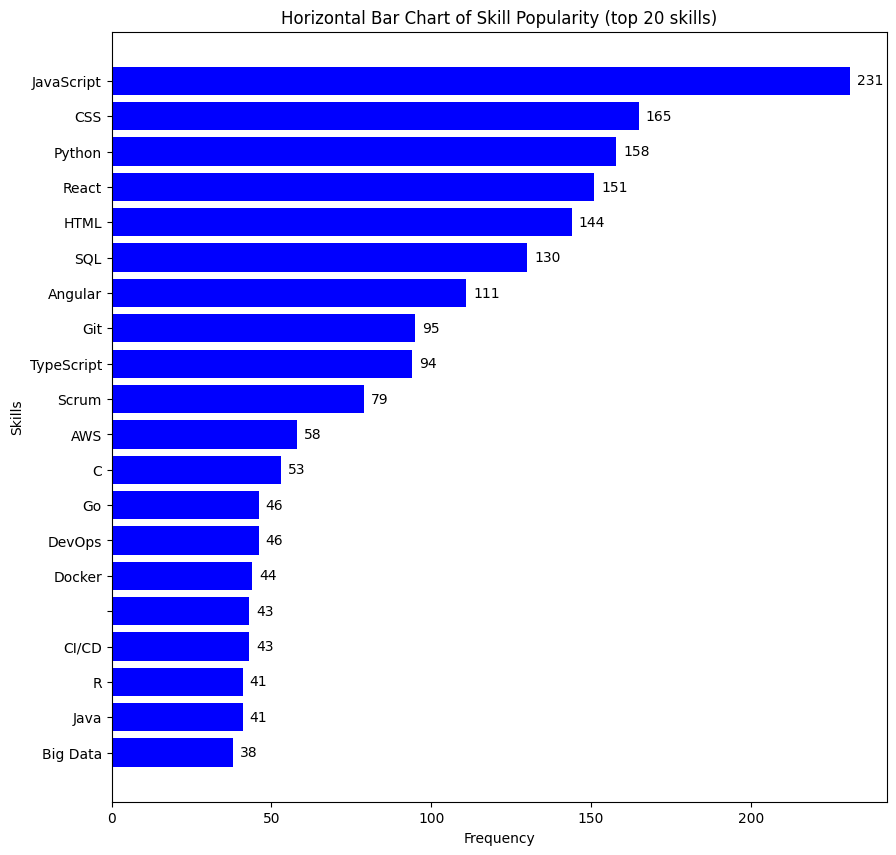

In [55]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Split skills and expand the DataFrame
df['skills'] = df_filled['skills'].str.split(',')
df_expanded = df.explode('skills')

* Plot top skills to make sure data is clean

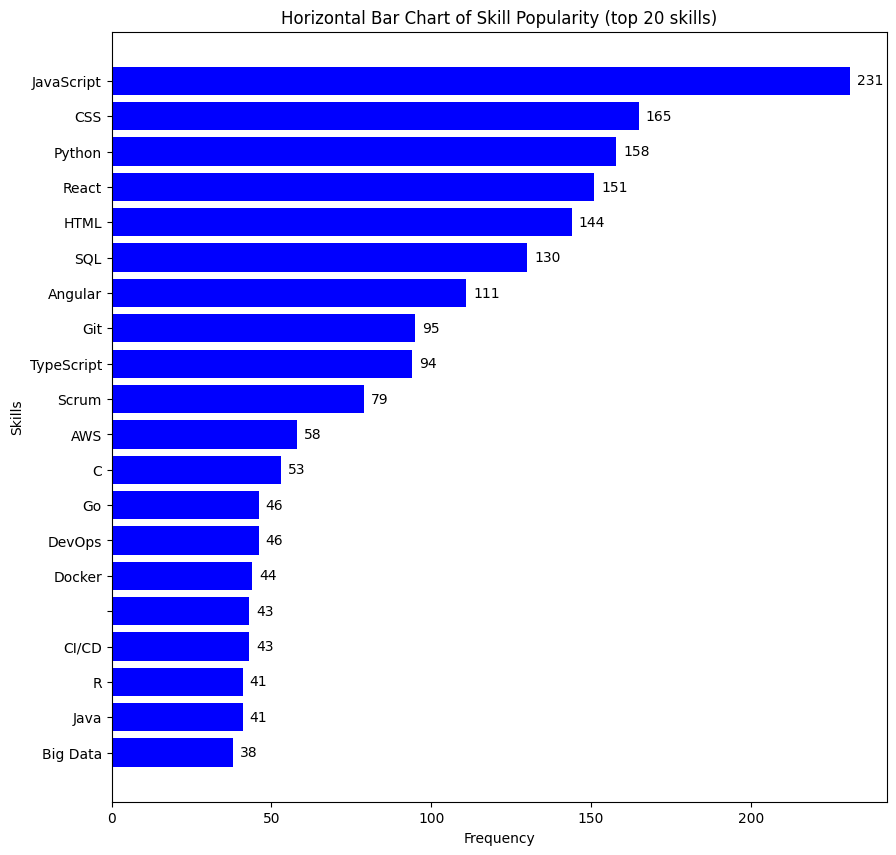

In [57]:
skill_counts = df_expanded['skills'].str.strip().value_counts()
sorted_skills = skill_counts.sort_values(ascending=False)

# Create a new DataFrame for all skills and their frequency
skills_df = pd.DataFrame(
    {'skill': sorted_skills.index, 'frequency': sorted_skills.values})

# Filter the skills to display the top ones
max_skills = 20
top_skills_df = skills_df.head(max_skills)

# Plot the horizontal bar chart of skill frequency
plt.figure(figsize=(10, max_skills/2))  # Adjust the figure size
bars = plt.barh(top_skills_df['skill'],
                top_skills_df['frequency'], color='blue')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title(
    f'Horizontal Bar Chart of Skill Popularity (top {max_skills} skills)')

# Annotate the frequency value on each bar
for bar in bars:
    frequency = bar.get_width()
    plt.annotate(str(frequency), xy=(frequency, bar.get_y() + bar.get_height() / 2),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.gca().invert_yaxis()  # Invert the y-axis to show the most popular skills on top
plt.show()
